In [3]:
pip install catboost

     |████████████████████████████████| 76.6 MB 93 kB/s              
     |████████████████████████████████| 46 kB 5.9 MB/s             
You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_log_error

In [5]:
# зафиксируем сид
random.seed(42)

## Загрузка данных

In [6]:
# колонки для группировки
AGG_COLS = ["material_code", "company_code", "country", "region", "manager_code"]

In [7]:
# данные
data = pd.read_csv('sc2021_train_deals.csv', parse_dates=["month", "date"])

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92306 entries, 0 to 92305
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   material_code       92306 non-null  int64         
 1   company_code        92306 non-null  int64         
 2   country             92306 non-null  object        
 3   region              92306 non-null  object        
 4   manager_code        92306 non-null  int64         
 5   month               92306 non-null  datetime64[ns]
 6   material_lvl1_name  92306 non-null  object        
 7   material_lvl2_name  92306 non-null  object        
 8   material_lvl3_name  92306 non-null  object        
 9   contract_type       92306 non-null  object        
 10  date                92306 non-null  datetime64[ns]
 11  volume              92306 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 8.5+ MB


In [9]:
print(f'В данных {data.shape[0]} строчек и {data.shape[1]} колонок.')

В данных 92306 строчек и 12 колонок.


In [10]:
# временной диапозон выборки
data['date'].min(), data['date'].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2020-07-31 00:00:00'))

## Декомпозиция временного ряда:

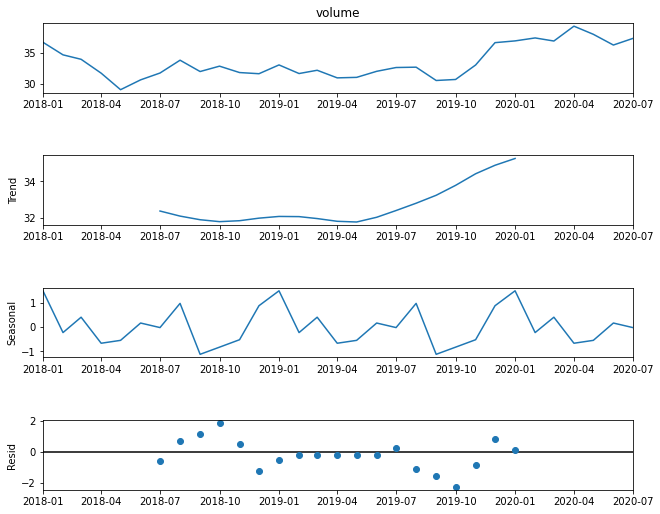

In [11]:
train_plot = data.set_index('date')
y = train_plot['volume'].resample('MS').mean()

result = sm.tsa.seasonal_decompose(y, model='additive')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 8)

- ряд не является стационарным;
- после продолжительного отсутствия какого-либо тренда, с мая 2019г. начался тренд на повышение продаж;
- видим сезонность: пики продаж наблюдаются в августе и январе;
- остатки располагаются рандомно вокруг 0

## Временные ряды по каждой группе:

In [12]:
group_ts = data.groupby(AGG_COLS + ['month'])['volume'].sum().unstack(fill_value=0)

group_ts

month 
 2018-01-01 
 2018-02-01 
 2018-03-01 
 2018-04-01 
 2018-05-01 
 2018-06-01 
 2018-07-01 
 2018-08-01 
 2018-09-01 
 2018-10-01 
 ... 
 2019-10-01 
 2019-11-01 
 2019-12-01 
 2020-01-01 
 2020-02-01 
 2020-03-01 
 2020-04-01 
 2020-05-01 
 2020-06-01 
 2020-07-01 
 
 
 material_code 
 company_code 
 country 
 region 
 manager_code 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 124 
 7278 
 Россия 
 Респ. Татарстан 
 17460 
 340.0 
 340.0 
 260.0 
 240.0 
 220.0 
 220.0 
 220.0 
 220.0 
 220.0 
 280.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 133 
 0 
 Белоруссия 
 Минская обл. 
 10942 
 0.0 
 0.0 
 0.0 
 200.0 
 60.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 181.0 
 208.0 
 207.0 
 17.0 
 72.0 
 250.0 
 394.0 
 288.0 
 210.0 
 249.0 
 
 
 Могилевская обл. 
 10942 
 0.0 
 0.0 
 0.0 
 0.0 
 140.0 
 0.0 
 0.0 
 0.0 
 100.0 
 220.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 166.0 
 62.0 
 0.0 
 0.0 
 
 
 г. Минск 
 10942 
 0.0 
 20.0 
 0.0 
 0.0 
 40.0 
 160.0 
 180.0 
 99.0 
 60.0 
 400.0 
 ... 
 82.0 
 42.0 
 0.0 
 0.0 
 0.0 
 0.0 
 21.0 
 0.0 
 0.0 
 6.0 
 
 
 Казахстан 
 г. Нур-Султан 
 13301 
 0.0 
 0.0 
 30.0 
 30.0 
 0.0 
 0.0 
 40.0 
 20.0 
 40.0 
 30.0 
 ... 
 45.0 
 50.0 
 45.0 
 0.0 
 50.0 
 40.0 
 0.0 
 0.0 
 50.0 
 0.0 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 986 
 9943 
 Россия 
 Смоленская обл. 
 17460 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 21.0 
 63.0 
 125.0 
 84.0 
 84.0 
 83.0 
 
 
 998 
 0 
 Россия 
 Ленинградская обл. 
 18079 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 4.0 
 5.0 
 5.0 
 ... 
 10.0 
 0.0 
 6.0 
 5.0 
 5.0 
 5.0 
 0.0 
 3.0 
 3.0 
 9.0 
 
 
 3380 
 Россия 
 Ленинградская обл. 
 14956 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 115.0 
 102.0 
 29.0 
 73.0 
 74.0 
 122.0 
 100.0 
 15.0 
 30.0 
 50.0 
 
 
 5410 
 Россия 
 г. Санкт-Петербург 
 14956 
 60.0 
 60.0 
 100.0 
 60.0 
 60.0 
 80.0 
 80.0 
 100.0 
 80.0 
 80.0 
 ... 
 120.0 
 140.0 
 100.0 
 100.0 
 180.0 
 180.0 
 100.0 
 140.0 
 40.0 
 0.0 
 
 
 6346 
 Россия 
 Респ. Башкортостан 
 10737 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 40.0 
 40.0 
 40.0 
 40.0 
 0.0 
 20.0 
 40.0 
 20.0 
 21.0 
 21.0 
 
 
 
 941 rows × 31 columns

Подготовим датасет для генерации новых признаков:

In [13]:
df = pd.DataFrame(group_ts.stack()).reset_index()

df = df.rename(columns={0: 'volume'})

Прологорифмируем целевую переменную:

In [14]:
df['volume'] = np.log1p(df['volume'])

In [15]:
df.head()

,material_code,company_code,country,region,manager_code,month,volume
0,124,7278,Россия,Респ. Татарстан,17460,2018-01-01,5.831882
1,124,7278,Россия,Респ. Татарстан,17460,2018-02-01,5.831882
2,124,7278,Россия,Респ. Татарстан,17460,2018-03-01,5.564520
3,124,7278,Россия,Респ. Татарстан,17460,2018-04-01,5.484797
4,124,7278,Россия,Респ. Татарстан,17460,2018-05-01,5.398163


## Feature Engineering

Сгенерируем новые признаки:
- лаги на 3/6/12/18 месяцев;
- скользящие среднее/минимум/максиму в периоде 3/6/12/18 месяцев.

Во избежание переобучения, будем добавлять к каждому значению шум.

In [16]:
class FeatureEngineering:
  """
  Создает новые признаки:
  1. Lag признаки;
  2. Скользящие средние;
  """

  def __init__(self, df):
    self.df = df

  # генерация случайного шума случайный шум
  def random_noise(self):
      return np.abs(np.random.normal(scale=0.1, size=(len(self.df),))) 

  # lag признаки
  def lag_features(self):
    lags = [3, 6, 9, 12, 18] 
    for lag in lags:
      self.df['sales_lag_' + str(lag)] = self.df.groupby(AGG_COLS)['volume'].transform(
          lambda x: x.shift(lag)) + self.random_noise() # Adding random noise to each value.
      
    return self.df

  # скользящие аггрегированные признаки
  def roll_agg_features(self):
    windows = [3, 6, 9, 12, 18] 
    for window in windows:
        self.df['sales_roll_mean_' + str(window)] = self.df.groupby(AGG_COLS)['volume']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window,
                                         min_periods=3,
                                         win_type="triang").mean()) + self.random_noise()
        
        self.df['sales_roll_max_' + str(window)] = self.df.groupby(AGG_COLS)['volume']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window,
                                         min_periods=3).max()) + self.random_noise()
        
        self.df['sales_roll_min_' + str(window)] = self.df.groupby(AGG_COLS)['volume']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window,
                                         min_periods=3).min()) + self.random_noise()

    return self.df


  # применение обоих методов
  def transform(self):
    self.df = self.lag_features()
    self.df = self.roll_agg_features()
    
    return self.df

In [17]:
# применим класс к датасету
fe_data = FeatureEngineering(df).transform()

In [18]:
fe_data

,material_code,company_code,country,region,manager_code,month,volume,sales_lag_3,sales_lag_6,sales_lag_9,...,sales_roll_min_6,sales_roll_mean_9,sales_roll_max_9,sales_roll_min_9,sales_roll_mean_12,sales_roll_max_12,sales_roll_min_12,sales_roll_mean_18,sales_roll_max_18,sales_roll_min_18
0,124,7278,Россия,Респ. Татарстан,17460,2018-01-01,5.831882,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,124,7278,Россия,Респ. Татарстан,17460,2018-02-01,5.831882,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,124,7278,Россия,Респ. Татарстан,17460,2018-03-01,5.564520,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,124,7278,Россия,Респ. Татарстан,17460,2018-04-01,5.484797,5.855210,NaN,NaN,...,5.576686,5.899193,5.860246,5.793493,5.877886,5.894578,5.645863,5.803149,5.839851,5.801344
4,124,7278,Россия,Респ. Татарстан,17460,2018-05-01,5.398163,5.835376,NaN,NaN,...,5.491870,5.752222,5.838854,5.553144,5.771779,5.901242,5.551352,5.761179,5.843872,5.580226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29166,998,6346,Россия,Респ. Башкортостан,10737,2020-03-01,3.044522,3.714815,3.155480,0.050371,...,0.067897,2.936926,3.893617,0.068858,2.501319,3.719632,0.098273,1.634493,3.732514,0.204913
29167,998,6346,Россия,Респ. Башкортостан,10737,2020-04-01,3.713572,3.748489,3.805712,3.051037,...,0.080341,3.086690,3.788532,0.162057,2.632452,3.794288,0.135554,1.893120,3.755923,0.271866
29168,998,6346,Россия,Респ. Башкортостан,10737,2020-05-01,3.044522,0.103048,3.875837,0.147782,...,0.003238,3.157812,3.813795,0.046976,2.784837,3.790659,0.025476,2.017177,3.779148,0.054513
29169,998,6346,Россия,Респ. Башкортостан,10737,2020-06-01,3.091042,3.049681,3.747657,3.245626,...,0.035741,3.121525,3.768457,0.145946,2.958790,3.909335,0.083615,2.338707,3.752017,0.084668


## Моделирование

Для прогноза будем использовать модель CatBoostRegressor.

Сначала обучимся и провалидируемся на отложенной выборке, а затем используем кросс-валидацию.

### Отложенная выборка

In [19]:
# периоды тренировочной, валидационной и тестовой выборок
tr_range = pd.date_range("2019-01-01", "2019-10-01", freq="MS")
val_range = pd.date_range("2019-11-01", "2020-02-01", freq="MS")
ts_range = pd.date_range("2020-03-01", "2020-07-01", freq="MS")

In [20]:
# разбиение на тренировочную, валидационную  и тренировочную выборки
train_data = fe_data[fe_data['month'].isin(tr_range)]
val_data = fe_data[fe_data['month'].isin(val_range)]
test_data = fe_data[fe_data['month'].isin(ts_range)]

In [25]:
# категориальные колонки
CAT_COLS = ["material_code", "company_code", "country", "region", "manager_code", "month"]
# обучающие признаки
FTS_COLS = fe_data.drop(['volume'], axis=1).columns
# целевая переманная
TARGET = "volume"
# type(month) -> str
train_data['month'] = train_data['month'].astype(str)
val_data['month'] = val_data['month'].astype(str)
test_data['month'] = test_data['month'].astype(str)

assert train_data['month'].dtypes == 'object', "['month'].dtypes должен быть str"
assert val_data['month'].dtypes == 'object', "['month'].dtypes должен быть str"
assert test_data['month'].dtypes == 'object', "['month'].dtypes должен быть str"

<ipython-input-25-3e7a0ea2e09c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['month'] = train_data['month'].astype(str)
<ipython-input-25-3e7a0ea2e09c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['month'] = val_data['month'].astype(str)
<ipython-input-25-3e7a0ea2e09c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [26]:
X_train = train_data[FTS_COLS]
X_val = val_data[FTS_COLS]
X_test = test_data[FTS_COLS]

y_train = train_data[TARGET]
y_val = val_data[TARGET]
y_test = test_data[TARGET]

In [41]:
# инициализация модели
model = CatBoostRegressor(iterations=10000,
                          early_stopping_rounds=100,
                          depth=6,
                          cat_features=CAT_COLS,
                          random_state=82736,
                          verbose=50
                          )
# обучение модели
model.fit(X_train, y_train, eval_set=(X_val, y_val))

Learning rate set to 0.017773
0:	learn: 2.1949183	test: 2.2003320	best: 2.2003320 (0)	total: 22.6ms	remaining: 3m 46s
50:	learn: 1.6922450	test: 1.8138744	best: 1.8138744 (50)	total: 1.01s	remaining: 3m 16s
100:	learn: 1.5633727	test: 1.7348922	best: 1.7348922 (100)	total: 1.68s	remaining: 2m 44s
150:	learn: 1.5167107	test: 1.7200107	best: 1.7200107 (150)	total: 2.31s	remaining: 2m 30s
200:	learn: 1.4913491	test: 1.7177883	best: 1.7173200 (180)	total: 2.91s	remaining: 2m 21s
250:	learn: 1.4751493	test: 1.7162907	best: 1.7160182 (238)	total: 3.5s	remaining: 2m 15s
300:	learn: 1.4631252	test: 1.7183387	best: 1.7159378 (253)	total: 4.13s	remaining: 2m 13s
350:	learn: 1.4532017	test: 1.7186451	best: 1.7159378 (253)	total: 4.75s	remaining: 2m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.71593782
bestIteration = 253

Shrink model to first 254 iterations.


In [43]:
# прогноз
train_preds = np.expm1(model.predict(X_train))
val_preds = np.expm1(model.predict(X_val))
test_preds = np.expm1(model.predict(X_test))

# оценка модели
print("RMSLE на тренировочной выборке:",
      f'{mean_squared_log_error(np.expm1(y_train), train_preds, squared=False):.4f}')
print("RMSLE на валидационной выборке:",
      f'{mean_squared_log_error(np.expm1(y_val), val_preds, squared=False):.4f}')
print("RMSLE на тестовой выборке:",
      f'{mean_squared_log_error(np.expm1(y_test), test_preds, squared=False):.4f}')

RMSLE на тренировочной выборке: 1.4603
RMSLE на валидационной выборке: 1.7159
RMSLE на тестовой выборке: 1.7820


Важность признаков:

In [40]:
pd.Series(model.feature_importances_, index=FTS_COLS).sort_values(ascending=False)

Видим, что скользящие среднее/максимум/мининум за 3 месяца - самые важные признаки.

### Cross-Validation

Для реализации кросс-валидиции, используем алгоритм TimeSeriesSplit, который разбивает данные таким образом, что тестовая выборка всегда из будущего периода времени, что позволяет избежать ликов и переобучения.

In [44]:
from sklearn.model_selection import TimeSeriesSplit

In [45]:
# инициализация базовой модели
base_model = CatBoostRegressor(iterations=10000,
                              early_stopping_rounds=100,
                              depth=6,
                              cat_features=CAT_COLS,
                              random_state=82736,
                              verbose=100)

In [68]:
# количество сплитов
splits = 5
# randon state
RS = 82736
# инициализация cv-модели
ts_cv = TimeSeriesSplit(n_splits=splits, test_size=941*2)
# список для хранения ошибок
ts_cv_losses = []
# month.dtypes -> str
fe_data['month'] = fe_data['month'].astype(str)

for fold, (train_idx, test_idx) in enumerate(ts_cv.split(fe_data)):
    print(f'    Фолд {fold}\n')
    # разбиваем выборку на трейн/тест
    X_train = fe_data[FTS_COLS].iloc[train_idx]
    X_test = fe_data[FTS_COLS].iloc[test_idx]
    y_train = fe_data[TARGET].iloc[train_idx]
    y_test = fe_data[TARGET].iloc[test_idx]
    # обучаемая модель
    model = CatBoostRegressor(iterations=10000,
                              early_stopping_rounds=100,
                              depth=6,
                              cat_features=CAT_COLS,
                              random_state=RS * fold,
                              verbose=100)
    # обучение модели
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    # прогноз
    ts_pred = np.expm1(model.predict(X_test))
    # ошибка
    test_loss = np.sqrt(mean_squared_log_error(np.expm1(y_test), ts_pred))
    
    ts_cv_losses.append(test_loss)

    print(f'\nRMSLE:{test_loss: .4f}\n')
    
    # сохраняем модель
    model.save_model(f"cv_model_{fold}.cbm")

    Фолд 0

Learning rate set to 0.019968
0:	learn: 2.2457142	test: 1.8834126	best: 1.8834126 (0)	total: 21ms	remaining: 3m 30s
100:	learn: 1.6682384	test: 1.3790542	best: 1.3790542 (100)	total: 2.07s	remaining: 3m 23s
200:	learn: 1.6057944	test: 1.3492153	best: 1.3492153 (200)	total: 4.09s	remaining: 3m 19s
300:	learn: 1.5780156	test: 1.3377721	best: 1.3376707 (299)	total: 6.09s	remaining: 3m 16s
400:	learn: 1.5571415	test: 1.3324943	best: 1.3320149 (385)	total: 8.1s	remaining: 3m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.332014941
bestIteration = 385

Shrink model to first 386 iterations.

RMSLE: 1.3320

    Фолд 1

Learning rate set to 0.020255
0:	learn: 2.2161089	test: 2.2762407	best: 2.2762407 (0)	total: 22.4ms	remaining: 3m 44s
100:	learn: 1.6420017	test: 1.6509739	best: 1.6509739 (100)	total: 2.24s	remaining: 3m 39s
200:	learn: 1.5809549	test: 1.6184520	best: 1.6183913 (199)	total: 4.46s	remaining: 3m 37s
300:	learn: 1.5548037	test: 1.6188897	best:

In [70]:
print(f'Средний RMSLE на тестовой выбокре:{np.mean(ts_cv_losses): .4f}')

Средний RMSLE на тестовой выбокре: 1.6181


С использованием кросс-валидации ошибка упала на 0.16.

## Формирование загрузки

In [71]:
%%writefile predict.py

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

AGG_COLS = ["material_code", "company_code", "country", "region", "manager_code"]

FOLDS = 5

class FeatureEngineering:
  """
  Создает новые признаки:
  1. Lag признаки;
  2. Скользящие средние;
  """

  def __init__(self, df):
    self.df = df

  # генерация случайного шума случайный шум
  def random_noise(self):
      return np.abs(np.random.normal(scale=0.1, size=(len(self.df),))) 

  # lag признаки
  def lag_features(self):
    lags = [3, 6, 9, 12, 18] 
    for lag in lags:
      self.df['sales_lag_' + str(lag)] = self.df.groupby(AGG_COLS)['volume'].transform(
          lambda x: x.shift(lag)) + self.random_noise() # Adding random noise to each value.
      
    return self.df

  # скользящие аггрегированные признаки
  def roll_agg_features(self):
    windows = [3, 6, 9, 12, 18] 
    for window in windows:
        self.df['sales_roll_mean_' + str(window)] = self.df.groupby(AGG_COLS)['volume']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window,
                                         min_periods=3,
                                         win_type="triang").mean()) + self.random_noise()
        
        self.df['sales_roll_max_' + str(window)] = self.df.groupby(AGG_COLS)['volume']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window,
                                         min_periods=3).max()) + self.random_noise()
        
        self.df['sales_roll_min_' + str(window)] = self.df.groupby(AGG_COLS)['volume']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window,
                                         min_periods=3).min()) + self.random_noise()

    return self.df


  # применение обоих методов
  def transform(self):
    self.df = self.lag_features()
    self.df = self.roll_agg_features()
    
    return self.df



def predict(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """
    Вычисление предсказаний.

    Параметры:
        df:
          датафрейм, содержащий все сделки с начала тренировочного периода до `month`; типы
          колонок совпадают с типами в ноутбуке `[SC2021] Baseline`,
        month:
          месяц, для которого вычисляются предсказания.

    Результат:
        Датафрейм предсказаний для каждой группы, содержащий колонки:
            - `material_code`, `company_code`, `country`, `region`, `manager_code`,
            - `prediction`.
        Предсказанные значения находятся в колонке `prediction`.
    """

    group_ts = df.groupby(AGG_COLS + ["month"])["volume"].sum().unstack(fill_value=0)
    group_ts[month] = 0
    new_df = pd.DataFrame(group_ts.stack()).reset_index()
    new_df = new_df.rename(columns={0: 'volume'})
    new_df['volume'] = np.log1p(new_df['volume'])
    fe_data = FeatureEngineering(new_df).transform()
    fe_data['month'] = fe_data['month'].astype(str)

    predicting_data = fe_data[fe_data['month'] == str(month)[:10]].reset_index()

    model = CatBoostRegressor()
    predictions = pd.DataFrame()
    for i in range(FOLDS):
      model_path = f'cv_model_{i}.cbm'
      model.load_model(model_path)
      prediction = model.predict(predicting_data[model.feature_names_])
      predictions[f'prediction_{i}'] = prediction

    preds_df = predicting_data[AGG_COLS].copy()
    preds_df["prediction"] = np.expm1(np.mean(predictions, axis=1))

    return preds_df

Overwriting predict.py


Проверим правильность работы загрузки:

In [72]:
import predict

In [73]:
predict.predict(data, pd.Timestamp("2020-08-01"))

,material_code,company_code,country,region,manager_code,prediction
0,124,7278,Россия,Респ. Татарстан,17460,0.670721
1,133,0,Белоруссия,Минская обл.,10942,105.060142
2,133,0,Белоруссия,Могилевская обл.,10942,2.690266
3,133,0,Белоруссия,г. Минск,10942,2.306920
4,133,0,Казахстан,г. Нур-Султан,13301,10.276427
...,...,...,...,...,...,...
936,986,9943,Россия,Смоленская обл.,17460,50.227789
937,998,0,Россия,Ленинградская обл.,18079,3.807949
938,998,3380,Россия,Ленинградская обл.,14956,24.371873
939,998,5410,Россия,г. Санкт-Петербург,14956,20.243439


Загрузка отработала корректно.

Сформируем zip-файл

In [74]:
from zipfile import ZipFile

In [75]:
zipObj = ZipFile('sub_1.zip', 'w')
for i in range(5):
    zipObj.write(f"cv_model_{i}.cbm")
zipObj.write('predict.py')
zipObj.write('requirements.txt')
zipObj.close()